# Approximating Eigenvectors and Eigenvalues 2: The $QR$ Algorithm

When the assumptions are met, power iteration combined with Rayleigh quotient approximation works beautifully to produce the principal eigenvector of a matrix and its associated eigenvalue, but for many applications we want not just the principal eigenvector and eigenvalue but all of the eigenvalues and eigenvectors of a matrix. To motivate why, we will first consider a new application: Principal Component Analysis (PCA). We will introduce an algorithm based on the $A=QR$ factorization for obtaining all of the eigenvalues of a matrix. Once we have the eigenvalues, we can then solve $(A-\lambda I)\mathbf{x} = \mathbf{0}$ for the eigenvectors.

## Principal Component Analysis

Principal component analysis is a dimensionality reduction technique used in statistics and machine learning. The idea behind it is to first transform one's dataset into a new coordinate system based on the directions of greatest variation in the dataset, and then to discard 'low variance' features, thus reducing the dimensionality of the dataset while preserving most of the variance. The directions of variation in a dataset can be identified as the eigenvectors of the datasets *covariance* matrix (defined below), and the relative magnitude of the associated eigenvalues can be used to guide us to the high variance directions.

```{admonition} The Covariance Matrix

Let $X$ represent a dataset consisting of $n$ observations with $p$ features, and let $\bar{X}$ be the $n\times p$ matrix with the column means of $X$ as columnwise components; that is, for all $i$, the entry in position $i, j$ of $\bar{X}$ is the mean of column $j$. Then the $p\times p$ matrix 

$$
    Cov(X) = \frac{1}{n-1}(X - \bar{X})^T(X - \bar{X})
$$

is called the *covariance matrix* of $X$. The entry in position $i, j$ of $Cov(X)$ is the covariance of features $i$ and $j$ from $X$. 
```

Note in the above definition of $Cov(X)$ the product $(X - \bar{X})^T(X - \bar{X})$. Products of this form have come up repeatedly, in contexts such as projections and linear regression (ordinary least squares). A product like this of the form $A^TA$ produces a symmetric matrix, and every real symmetric matrix will have real eigenvalues and orthogonal eigenvectors. Suppose we find the eigenvalues and eigenvectors of Cov(X) and we order the eigenvalues - and their associated eigenvectors - from greatest to least magnitude. We can select a subset of the eigenvectors to serve as a new basis for the dataset, and then we can project the data onto this subset. More precisely, given an $n\times p$ matrix $X$, PCA is done as follows.

```{admonition} Principal Component Analysis Algorithm
1. Find the eigenvalues and eigenvectors of the $p\times p$ symmetric $Cov(X)$ and sort them in order of decreasing magnitude of the eigenvalues.
2. For $1\leq i\leq p$, calculate $g_j\sum_{j=1}^i \lambda_j$. Also calculate $g_{tot}=\sum_{j=1}^p \lambda_j$.
3. Determine $j$ such that $g_j / g_{tot} \geq \alpha$, where $\alpha$ is a predetermined threshold, often $0.9$.
4. Put the first $j$ eigenvectors of $Cov(X)$ into a $ p\times j$ matrix $W$.
5. Calculate the product $XW$. Use this lower-dimensional $n \times j$ matrix instead of the original dataset.
 ```

The idea behind the above algorithm is to find as small as possible a $j$ (i.e. reduce the dimension of the dataset as much as possible) while capturing as much of the variance in the dataset as possible ($g_j / g_{tot}$). Requiring $g_j / g_{tot} \geq 0.9$ is common, but depending on context other thresholds may be used.

## A 2D Example

We will illustrate how the eigenvectors of the covariance matrix point in the directions of greatest variance with an example in the plane using synthetic data. The data is normally distributed in x and y, then rotated  $45^{\circ}$ using a rotation matrix.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.linalg as la
import matplotlib.pyplot as plt

plt.style.use('bmh')

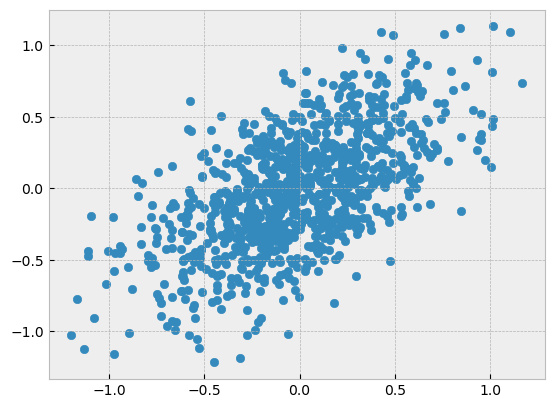

In [2]:
xs = np.random.normal(loc=0, scale=0.25, size=(1000, 1))
ys = np.random.normal(loc=0, scale=0.50, size=(1000, 1))

data = np.hstack([xs, ys])

A = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [-1/np.sqrt(2), 1/np.sqrt(2)]])

data = (A @ data.T).T

plt.scatter(data[:, 0], data[:, 1]);

Now let's calculate the covariance matrix of the dataset.

In [3]:
num_obs = data.shape[0]

# center X
X = (data - np.ones_like(data) * np.mean(data, axis=0)) 

# make Cov(X)
covX = (X.transpose() @ X ) / (num_obs - 1)

And get the eigenvalues and eigenvectors.

In [4]:
L, V = la.eig(covX)

Now, let's plot the eigenvectors of $Cov(X)$ along with the data:

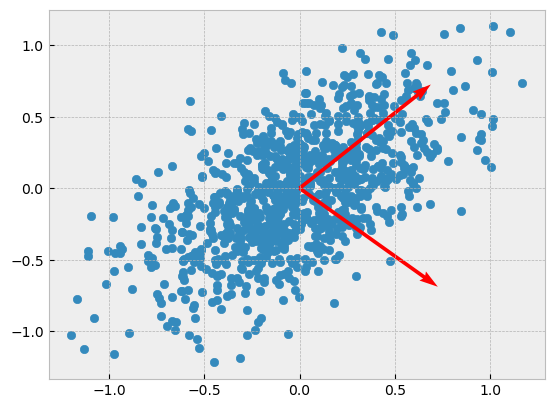

In [5]:
plt.scatter(data[:, 0], data[:, 1])
plt.quiver(0, 0, -V[0, 0], -V[1,0], angles='xy', scale_units='xy', scale=1, color='r')
plt.quiver(0, 0, -V[0, 1], -V[1,1], angles='xy', scale_units='xy', scale=1, color='r');

Scikit-Learn implements PCA very efficiently, so we can take advantage of it rather than go through the construction of $Cov(X)$ and the derivation of its eigenvectors and eigenvalues.

In [6]:
pca = PCA()
pca.fit(data)

PCA()

The 'explained variances' attribute in PCA are the eigenvalues of the covariance matrix. Note that PCA will always return these ordered from greatest to least magnitude. As you can see below, they are the same as the eigenvalues calculated directly up above, but our eigenvalue calculation from before did not return sorted eigenvalues.

In [7]:
# explained variances in PCA vs. eigenvalues of Cov(X)
pca.explained_variance_, L

(array([0.25305086, 0.0638602 ]), array([0.0638602 +0.j, 0.25305086+0.j]))

## A Larger Example

As described above, PCA is typically used to reduce the number of features in a dataset. When we have only two features to work with that isn't really possible without ending up with a trivial dataset; in the previous example the calculations of $g_j$ and $g_{tot}$ were skipped over entirely since there is nothing we can do with them. Let's now consider a larger, but still synthetic, example where we will select the minimal number of principal components necessary to capture 90% of the variance in the dataset. As noted above, the 90% is a choice we get to make.

In [8]:
# sklearn utility for generating a synthetic dataset

data, _ = make_classification(n_samples=1000, n_features=100, n_informative=10)

In [9]:
# Calculate Cov(X)

num_obs = data.shape[0]

# center X
X = (data - np.ones_like(data) * np.mean(data, axis=0)) 

# make Cov(X)
covX = (X.transpose() @ X ) / (num_obs - 1)

In [10]:
# get the eigenvalues and eigenvectors

L, V = la.eig(covX)

We can use NumPy's argsort function to sort L without losing track of the indices that we will need to identify the eigenvectors associated with the largest eigenvalues. NumPy sorts in ascending order, so we need to reverse the sorted order, then we can use the cumulative sum function to fill the array $g$ with values $g_j$.

In [11]:
# Calculate the gs

g_tot = L.sum()
idx = L.argsort()[::-1]
g = L[idx].cumsum()

# array with proportion of explained variance
exp_var = g / g_tot

# find at which index the explained variance is finally at least 90%
np.where(exp_var >= 0.9)[0][0]

np.int64(74)

Based on the above calculation, we need the first 72 principal components to capture 90% of the variance in the dataset.

How do we actually use this information? We need to transform our dataset. This can be done by multiplying the original dataset with a matrix containing the first 72 principal components:

In [12]:
transformed_data = data @ V[:, :72]

transformed_data.shape

(1000, 72)

The transformed dataset can now be used as a lower-dimensional replacement for the original dataset that still captures 90% of the variance present in the original dataset.

## A Real-World Example

The example below uses a famous dataset of digitized handwritten digits called the MNIST dataset. It has been widely used for training and benchmarking machine learning algorithms. A description of the dataset is output from the next cell.

In [13]:
mnist = fetch_openml('mnist_784', data_home='.')
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

The images in the dataset are vectorized already; the components of the vectors are 64-bit unsigned integer pixel values. A sample of the images are visualized below.

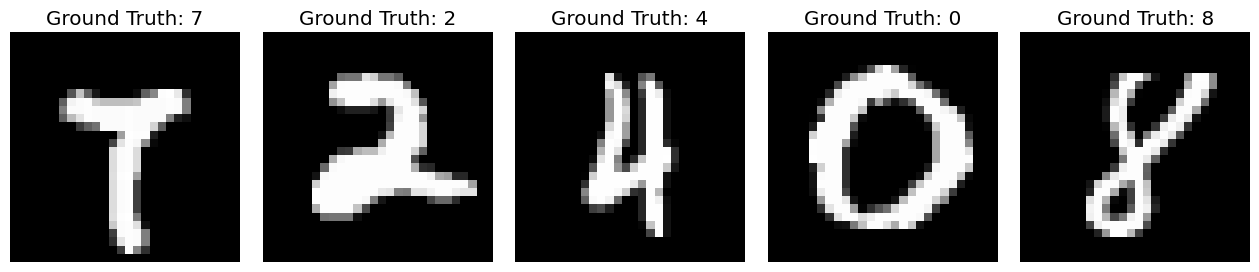

In [14]:
idx = np.random.randint(low=0, high=70000, size=5)
fig, ax = plt.subplots(1, 5, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)
for i in range(5):
    ax[i].imshow(mnist.data.loc[idx[i], :].values.reshape(28, 28), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Ground Truth: {int(mnist.target.loc[idx[i]])}')

The individual pixel values are not particularly informative, but the first two principal components of the dataset are. Below, they are plotted with each point colored by label. As you can see in the plot, although there is some overlap points with the same label generally cluster together. 

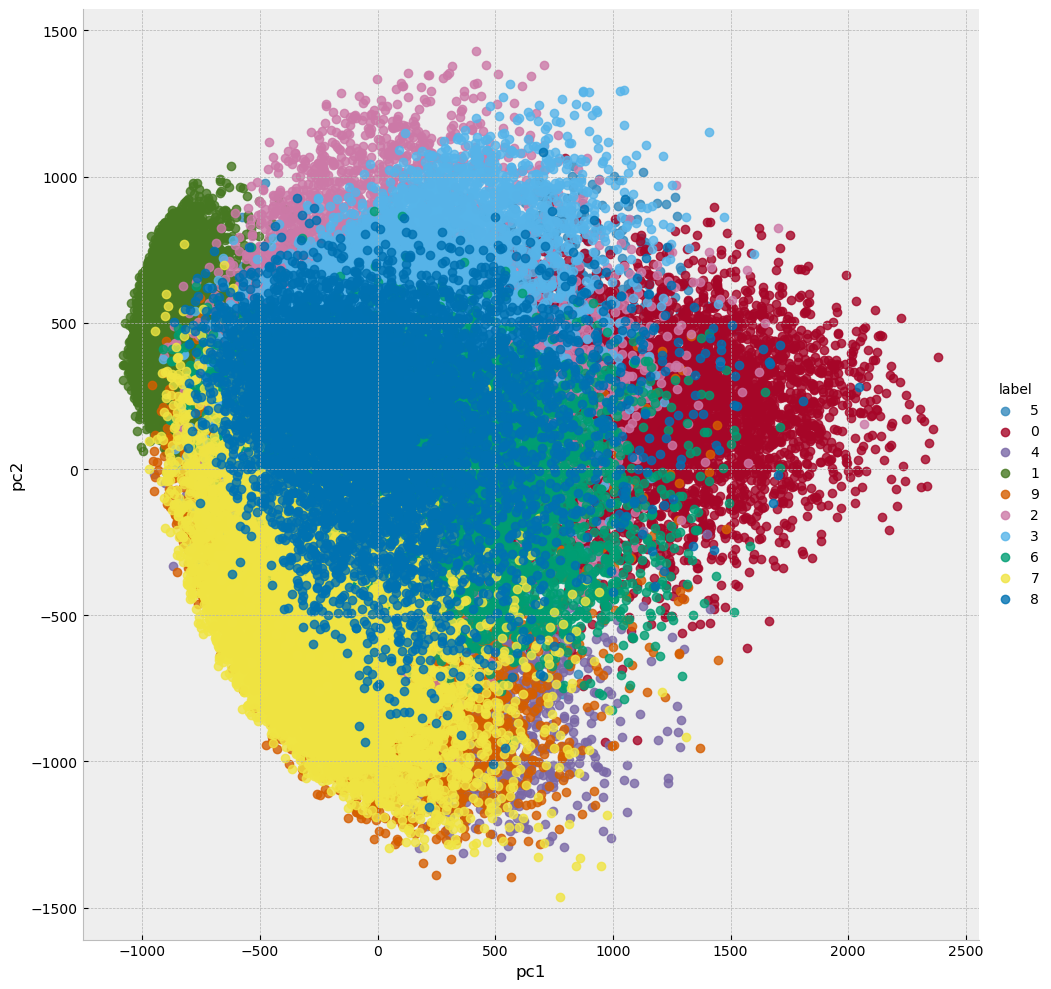

In [15]:
import pandas as pd
import seaborn as sns

pc = PCA(n_components=2).fit_transform(mnist.data)

pc_w_labels = np.hstack([pc, mnist.target.values.reshape(70000, 1)])
df = pd.DataFrame(pc_w_labels, columns=['pc1', 'pc2', 'label'])

sns.lmplot(x='pc1', y='pc2', hue='label', fit_reg=False, data=df, height=10);

The above plot only used the first two principal components. Let's look at the explained variances for all of the principal components.

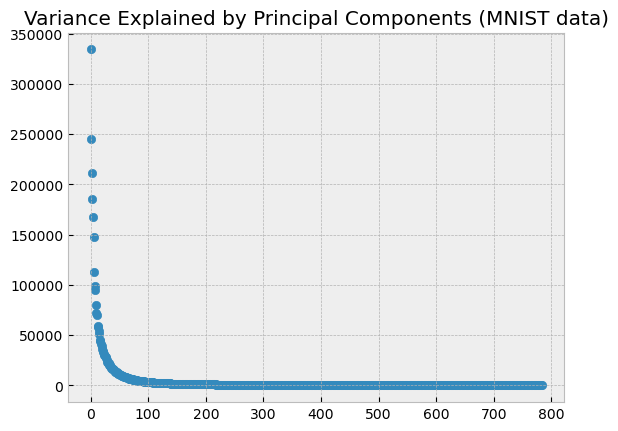

In [16]:
mnist_full_pca = PCA().fit(mnist.data)
explained_variance = mnist_full_pca.explained_variance_

plt.scatter(np.arange(len(explained_variance)), explained_variance)
plt.title('Variance Explained by Principal Components (MNIST data)');

As the plot above (plots like this are sometimes called *scree* plots) illustrates, most of the variance in the dataset is captured by the first approximately 100 principal components; the others provide very little information. It would be reasonable, then, to expect that a machine learning model could be efficiently trained to almost the same level of accuracy using only the first 100 principal components as it could be trained to achieve using all of the dataset. Let's illustrate this. We will train a machine learning model to predict the handwritten digits in the MNIST images, first using all 784 pixel values, and then using only the first 100 principal components, and we will compare the accuracy of the two approaches.

To do this correctly, we need to randomly split the data into two sets: a 'training' set and a 'test' set. The models will be fit on the training data, and they will be assessed at their ability to predict the handwritten digits in the images in the test set only. This way, the models cannot have any advance knowledge of the images on which their predictions are being assessed. This approach to model assessment is called *cross-validation*.

The architecture of the machine learning model that we use here is not important. If you are interested in the details, you can read about the random forest model [here](https://en.wikipedia.org/wiki/Random_forest#Algorithm). 

In [17]:
# randomly split the data into training and test sets

Xtr, Xte, ytr, yte = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=0)

In [18]:
# fit and assess a random forest model on the 784 component MNIST image vectors

full_rf = RF(n_estimators=25).fit(Xtr, ytr)
full_pred = full_rf.predict(Xte)
full_acc = accuracy_score(yte, full_pred)

In [19]:
# fit and assess a random forest model on the first 100 principal components of the MNIST data

# first determine the 100 principal components using only the training data
pca = PCA(n_components=100).fit(Xtr)

# transform the training and test sets using those principal components
pca_Xtr = pca.transform(Xtr)
pca_Xte = pca.transform(Xte)

In [20]:
# fit and assess the random forest model to the transformed data
pca_rf = RF(n_estimators=25).fit(pca_Xtr, ytr)
pca_pred = pca_rf.predict(pca_Xte)
pca_acc = accuracy_score(yte, pca_pred)

In [21]:
# compare the performance of the full model to the pca model
print(full_acc, pca_acc)

0.9595 0.9322857142857143


As expected, the model fit by first transforming the data using PCA performs nearly as well as the model fit using the full dataset, despite the fact that the transformed dataset is about 87% smaller than the full dataset.

## The QR Algorithm

PCA provides an example of an algorithm where we need to determine all of the eigenvectors and eigenvalues of a matrix. One of the most widely used algorithms for finding the eigenvalues of an arbitrary matrix without any special characteristics (such as symmetry) is based on the $A=QR$ decomposition of a matrix into an orthogonal matrix and an upper right triangular matrix and is called the $QR$ algorithm. The basic implementation of the algorithm is straightforward:

```{admonition} The $QR$ Algorithm
1. Let $A_1 = A$
2. For $t = 1,\dots$
    - Compute the $QR$ factorization $A_t = Q_tR_t$
    - Let $A_{t+1} = R_tQ_t$.
```

That is, at each iteration of the $QR$ algorithm, we calculate the $QR$ decomposition of $A$, then reverse the order of the terms and multiply to produce a 'new' $A$. We continue this for as many iterations as desired.

The output of this algorithm is a *quasi-triangular* matrix (defined precisely below) referred to as the *Schur* form of $A$, which in the best case will be diagonal, and because the eigenvalues of a diagonal matrix are precisely the diagonal entries we can simply read them off. If the output of the algorithm is not diagonal, it will still be in a form from which we can obtain the eigenvalues of $A$ without too much trouble as described below. And the algorithm is surprisingly robust: the only condition is that the eigenvalues of our matrix have distinct magnitudes.

Before we go further let's illustrate with an example.

In [22]:
A = np.array([[6, 1, 0, 0, 1], [2, 5, 1, 0, 0], [0, 1, 4, 1, 0], [0, 0, 2, 3, 1], [1, 0, 0, 1, 2]])

print('Matrix A below')
print('='*20)
print(A)
print('\n')

L, _ = la.eig(A)

A_new = A
for _ in range(100):
    Q, R = la.qr(A_new)
    A_new = R @ Q

print('Matrix A_{new} below')
print('='*20)
print(np.round(A_new, decimals=2))
print('\n')

print('eigenvalues of A obtained via SciPy below') 
print(L)

Matrix A below
[[6 1 0 0 1]
 [2 5 1 0 0]
 [0 1 4 1 0]
 [0 0 2 3 1]
 [1 0 0 1 2]]


Matrix A_{new} below
[[ 7.28 -0.38  0.64 -0.62  0.18]
 [ 0.    5.2  -0.58 -0.42  0.58]
 [ 0.    0.    4.2  -0.2   0.23]
 [ 0.   -0.    0.    2.28 -0.29]
 [ 0.   -0.    0.    0.    1.04]]


eigenvalues of A obtained via SciPy below
[7.28225117+0.j 5.20285268+0.j 4.19870499+0.j 2.27916578+0.j
 1.03702538+0.j]


As you can see, the (rounded off) eigenvalues of $A$ have spontaneously appeared on the diagonal of $A_{new}$.

Why this seemingly simple algorithm works is beyond the scope of this course to explain in full, but we will provide as much intuitive explanation as possible. In order to do so we need some definitions. 

```{admonition} Definition: Quasi-Triangular Matrix
A matrix $A$ is *quasi-triangular* if when expressed as a block matrix of $2\times 2$ and $1\times 1$ blocks is triangular.
```

Quasi-triangular matrices can be upper or lower quasi-triangular, or even quasi-diagonal. Below is an example of  a quasi upper triangular matrix.

*Example:* Let

$$
    A = \begin{bmatrix}
            1 & 2 & 2 & 4 \\
            2 & 1 & 0 & 3 \\
            0 & 0 & 1 & 3 \\
            0 & 0 & 4 & 4 \\
        \end{bmatrix}.
$$

$A$ is not triangular: the entries in positions $2, 1$ and $4, 3$ are below the diagonal. But if we write $A$ in terms of the $2\times 2$ blocks

$$
    B = \begin{bmatrix}
            1 & 2 \\
            2 & 1
        \end{bmatrix},
    C = \begin{bmatrix}
            2 & 4 \\
            0 & 3
        \end{bmatrix},
    D = \begin{bmatrix}
            1 & 3 \\
            4 & 4
        \end{bmatrix}
$$

and the $2\times 2$ zero matrix that we will simply denote with $0$, we have

$$
    A = \begin{bmatrix}
            B & C \\
            0 & D
        \end{bmatrix}
$$

which is triangular, so $A$ is quasi-triangular; indeed $A$ is quasi upper triangular.

It is straightforward to find the eigenvalues of a quasi-triangular matrix: they are the eigenvalues of the diagonal blocks. If a block is $2\times 2$, we can solve the characteristic equation for that block, and if the block is $1\times 1$ (just a single diagonal entry), the eigenvalue for that block is the entry.

**Example, continued:** The diagonal blocks of $A$ above are the matrices $B$ and $D$. The characteristic equation of $B$ is

$$
    \begin{align*}
        (1 - \lambda)(1-\lambda) - 4 &= 0 \\
        \lambda^2 - 2\lambda - 3 &= 0 \\
        (\lambda - 3)(\lambda + 1) &= 0,
    \end{align*}
$$

which is zero for $\lambda=-1, 3$. The characteristic equation for $D$ is 

$$
    \begin{align*}
        (1 - \lambda)(4-\lambda) - 12 &= 0 \\
        \lambda^2 - 5\lambda - 8 &= 0.
    \end{align*}
$$

That equation doesn't factor but we can obtain its roots with the quadratic formula: 

$$
    \lambda = \frac{5 \pm\sqrt{25 - 4\cdot1\cdot(-8)}}{2} = \frac{5}{2} \pm \frac{\sqrt{57}}{2} \approx 6.2749, -1.2749.
$$

Let's confirm that SciPy returns the same result.

In [23]:
A = np.array([[1, 2, 2, 4], [2, 1, 0, 3], [0, 0, 1, 3], [0, 0, 4, 4]])
L, V = la.eig(A)
print(L)

[ 3.        +0.j -1.        +0.j -1.27491722+0.j  6.27491722+0.j]


It is the case that every real square matrix can be decomposed into the product of orthogonal matrices and a quasi-triangular matrix. This is known as a Schur decomposition.

```{admonition} Theorem: The Schur Decomposition
Every real square matrix $A$ can be written in the form

$$
    A = QUQ^T
$$

where $Q$ is an orthogonal matrix and $U$ is a quasi upper-triangular matrix.
```

The above theorem implies that there exists an orthogonal matrix $Q$ such that $Q^TAQ$ is quasi-upper triangular.

With the above definitions and theorems in hand, we can explain in a bit more detail what the $QR$ algorithm does: it obtains an approximate Schur decomposition of $A$. Note that when we reverse $Q$ and $R$ and calculate $RQ$, we get

$$
    RQ = Q^TAQ,
$$

because if $A=QR$, then $R = Q^{-1}A$, but because $Q$ is orthogonal, $Q^{-1} = Q^T$. So $RQ$ and $A$ are similar matrices and thus have the same eigenvalues. At each iteration $Q$'s accumulate and the product of the $Q$'s converges to a matrix containing the eigenvectors of $A$, while at the same time the off-diagonal entries of $RQ$ are driven toward $0$. 

Let's revisit our first example using the algorithm and track $Q$ this time to see this in action.

In [24]:
A = np.array([[6, 1, 0, 0, 1], [2, 5, 1, 0, 0], [0, 1, 4, 1, 0], [0, 0, 2, 3, 1], [1, 0, 0, 1, 2]])

print('Matrix A below')
print('='*20)
print(A)
print('\n')

L, V = la.eig(A)

A_new = A
Q_new = np.eye(A.shape[0])
for _ in range(200):
    Q, R = la.qr(A_new)
    Q_new = Q_new @ Q
    A_new = R @ Q

print('Matrix A_{new} below')
print('='*20)
print(np.round(A_new, decimals=2))
print('\n')

print('eigenvalues of A obtained via SciPy below') 
print('='*20)
print(L)
print('\n')

print('estimated eigenvectors of A stored in Q_new below')
print('='*20)
print(Q_new)
print('\n')

print('eigenvectors of A obtained via SciPy below') 
print('='*20)
print(V)
print('\n')

Matrix A below
[[6 1 0 0 1]
 [2 5 1 0 0]
 [0 1 4 1 0]
 [0 0 2 3 1]
 [1 0 0 1 2]]


Matrix A_{new} below
[[ 7.28 -0.38  0.64 -0.62  0.18]
 [ 0.    5.2  -0.58 -0.42  0.58]
 [ 0.    0.    4.2  -0.2   0.23]
 [ 0.   -0.    0.    2.28 -0.29]
 [ 0.   -0.    0.    0.    1.04]]


eigenvalues of A obtained via SciPy below
[7.28225117+0.j 5.20285268+0.j 4.19870499+0.j 2.27916578+0.j
 1.03702538+0.j]


estimated eigenvectors of A stored in Q_new below
[[ 0.65053349 -0.44246486  0.50806133 -0.33227413 -0.11179723]
 [ 0.68172539  0.02590801 -0.63623951  0.35244707 -0.07456285]
 [ 0.2548016   0.62933016 -0.08423581 -0.60501288  0.4072879 ]
 [ 0.15459745  0.63358629  0.41576743  0.28517443 -0.56611043]
 [ 0.15242193  0.07788185  0.39637702  0.56392369  0.70397251]]


eigenvectors of A obtained via SciPy below
[[ 0.65053349  0.31742773 -0.13964281  0.26518015 -0.1631798 ]
 [ 0.68172539 -0.14885613  0.61300144 -0.36687543  0.03582117]
 [ 0.2548016  -0.66505132 -0.21190937  0.46784691  0.1844012 ]
 [ 0.1

## Computational Complexity of the QR Algorithm

The $QR$ algorithm is computationally expensive because the $QR$ decomposition is computationally expensive: calculating $A=QR$ is in general $\mathcal{O}(n^3)$, so doing this many times is prohibitive. In practice, there are a number of optimizations used; the most important of which is to begin by bringing our matrix to a form called *Hessenberg* form.  A matrix is in Hessenberg form if it has no nonzero entries below the first subdiagonal, which is the diagonal just below the main diagonal. Bringing a matrix to Hessenberg form is itself $\mathcal{O}(n^3)$ in general, but it can be shown that calculating the $QR$ decomposition of a matrix in Hessenberg form is $\mathcal{O}(n^2)$, so if we the matrix is reduced to Hessenberg form first running the algorithm is computationally far more tractable. 

Even with the best optimizations currently available, obtaining approximations to an arbitrary degree of accuracy of the eigenvalues and eigenvectors of very large matrices is often computationally intractable. In such situations iterative methods may be used to calculate some of the eigenvalues and eigenvectors based on some stopping condition: for example, an iterative method for PCA could halt when enough eigenvectors and eigenvalues have been calculated to explain the desired proportion of variance observed in the data. Such methods are less precise than exact full eigenvector and eigenvalue calculations, but may be the only choice. 

## Bonus: How is $A=QR$ Really Calculated?

When we first introduced the $QR$ decomposition, we described the Gram-Schmidt orthogonalization and used that to calculate it. This is not numerically stable and is generally not used in practice; instead, $A=QR$ is calculated using Householder transformations. Householder transformations are also used in obtaining Hessenberg form, so they do double-duty in an efficient $QR$ algorithm implementation. How Householder transformations are used to obtain $A=QR$ is described below.

```{admonition} Definition: Householder Matrix
Given a unit vector $\mathbf{v}$, the matrix

$$
    H = I - 2\mathbf{v}\mathbf{v}^T
$$

is called a Householder matrix.

Householder matrices are orthogonal matrices and are sometimes referred to as reflection matrices because they reflect vectors about the hyperplane orthogonal to the vector $\mathbf{v}$ used in their construction. This is illustrated in the visualization below.

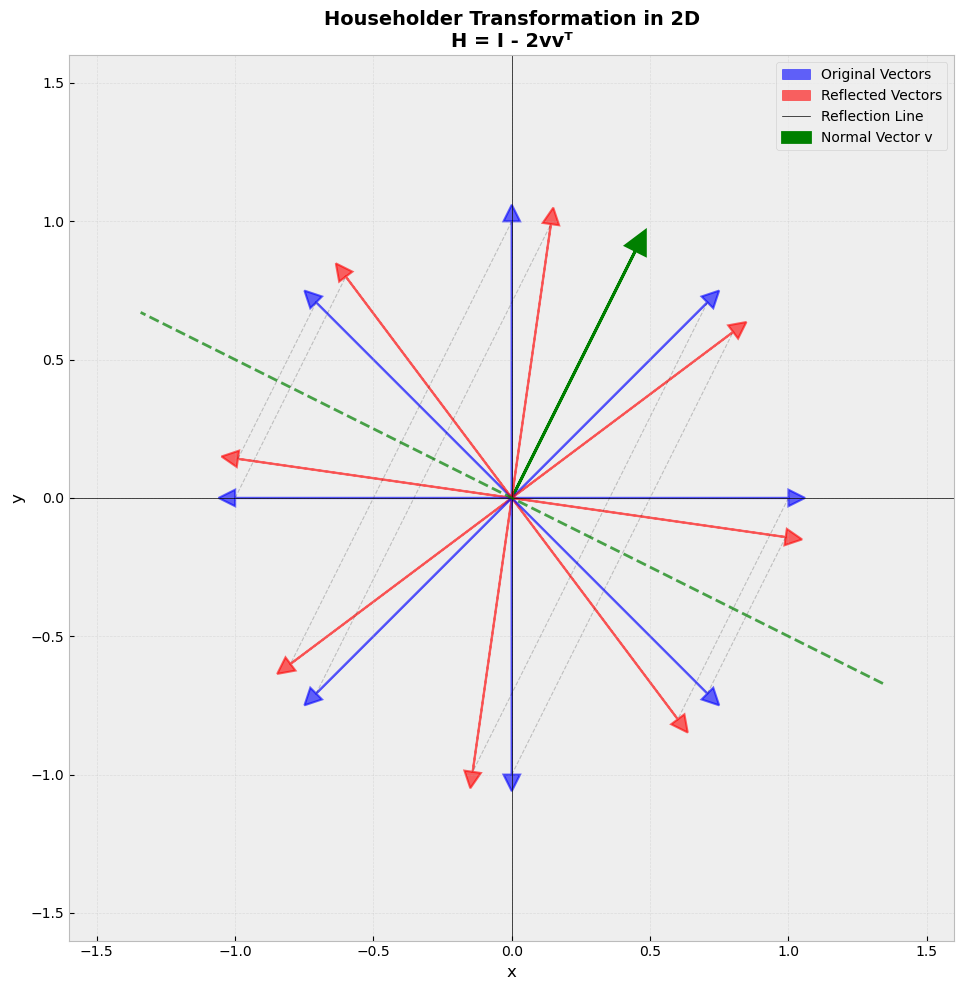

Householder Matrix H:
[[ 0.6 -0.8]
 [-0.8 -0.6]]

Normal vector v: [0.4472136  0.89442719]
Reflection line direction: [-0.89442719  0.4472136 ]


In [25]:
# Define a vector to reflect across (the normal to the reflection line)
v = np.array([1, 2])
v = v / np.linalg.norm(v)  # Normalize

# Create the Householder transformation matrix: H = I - 2vv^T
H = np.eye(2) - 2 * np.outer(v, v)

# Create some test vectors to transform
angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
vectors = np.array([[np.cos(a), np.sin(a)] for a in angles])

# Apply the Householder transformation
transformed = vectors @ H.T

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

# Plot the reflection line (perpendicular to v)
# The reflection line is spanned by the vector perpendicular to v
perp = np.array([-v[1], v[0]])
line_ext = 1.5
ax.plot([-line_ext*perp[0], line_ext*perp[0]], 
        [-line_ext*perp[1], line_ext*perp[1]], 
        'g--', linewidth=2, label='Reflection Line', alpha=0.7)

# Plot the normal vector v
ax.arrow(0, 0, v[0], v[1], head_width=0.08, head_length=0.08, 
         fc='green', ec='green', linewidth=2, label='Normal Vector v')

# Plot original and transformed vectors
for i, (orig, trans) in enumerate(zip(vectors, transformed)):
    # Original vectors in blue
    ax.arrow(0, 0, orig[0], orig[1], head_width=0.06, head_length=0.06,
             fc='blue', ec='blue', alpha=0.6, linewidth=1.5)
    
    # Transformed vectors in red
    ax.arrow(0, 0, trans[0], trans[1], head_width=0.06, head_length=0.06,
             fc='red', ec='red', alpha=0.6, linewidth=1.5)
    
    # Draw connecting lines to show the reflection
    ax.plot([orig[0], trans[0]], [orig[1], trans[1]], 
            'k--', alpha=0.2, linewidth=0.8)

# Create legend manually
from matplotlib.patches import FancyArrow
blue_arrow = FancyArrow(0, 0, 0.1, 0.1, width=0.01, 
                        facecolor='blue', edgecolor='blue', alpha=0.6)
red_arrow = FancyArrow(0, 0, 0.1, 0.1, width=0.01, 
                       facecolor='red', edgecolor='red', alpha=0.6)

ax.legend([blue_arrow, red_arrow, ax.get_lines()[0], ax.patches[0]], 
          ['Original Vectors', 'Reflected Vectors', 'Reflection Line', 'Normal Vector v'],
          loc='upper right', fontsize=10)

ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.6, 1.6)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Householder Transformation in 2D\nH = I - 2vvᵀ', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the transformation matrix
print("Householder Matrix H:")
print(H)
print(f"\nNormal vector v: {v}")
print(f"Reflection line direction: {perp}")

Now suppose we wish to find the $QR$ factorization of $A$. We will start with a very specific Householder matrix $Q_1$. Take $A_i$ to be an arbitrary column vector of $A$ with magnitude $||A_i|| = \alpha$. Set $\mathbf{u} = A_i - \alpha\mathbf{e}_1$, where $\mathbf{e}_1$ is the first standard basis vector, let $\mathbf{v} = \mathbf{u}/||\mathbf{u}||$, and define $Q_1=I-2\mathbf{v}\mathbf{v}^T$. Then 

$$
    Q_1A_i = \begin{bmatrix}
                \alpha \\
                0 \\
                \vdots \\
                0
            \end{bmatrix}.
$$

Verifying this is a good exercise. Now we can use this process to produce the $QR$ factorization of $A$ as follows. First, instead of multiplying $Q_1$ and the column $A_1$, multiply $Q_1$ and the whole matrix $A$ to produce

$$
    Q_1A = \left[\begin{array}{cccc}
                \alpha & * & \dots & * \\
                0 & & & \\
                \vdots & & A' & \\
                0 & & &
            \end{array}\right].
$$

Now extract $A'$ from the product above and repeat the procedure, picking an arbitrary column of $A'$ and determining a new $\alpha$, $\mathbf{u}$, and $\mathbf{v}$ based on it, from which a new Householder matrix $Q_2'$ can be constructed. Note, however, that $Q_2'$ will be smaller than $Q_1$, and we need them to be the same size for what follows. So define

$$
    Q_2 = \left[\begin{array}{cccc}
            1 & 0 & \dots & 0 \\
            \vdots & & Q_2' & \\
            0 & & & 
          \end{array}\right],
$$

and in general for $1 \leq k \leq n$,

$$
    Q_k = \left[\begin{array}{cc}
            I_{k-1} & 0 \\
            0 & Q_k'
          \end{array}\right].
$$

Iterating this process produces an upper triangular matrix $R = Q_tQ_{t-1}\cdots Q_1A$. Invert (transpose) the $Q_i$'s and we have $Q_1^TQ_2^T\cdots Q_t^TR = A$. The product of orthogonal matrices is an orthogonal matrix, so without loss of generality let $Q = Q_1^TQ_2^T\cdots Q_t^T$, and we have $A=QR$, the product of an orthogonal matrix and an upper triangular matrix, as desired.

**Example:** Let's walk through a small example in detail to illustrate the algorithm.

In [26]:
A = np.array([[2, 1, 2, 3], [1, 1, 2, 4], [2, 3, 4, 1], [1, 2, 3, 4]], dtype=np.float64)
print(A)

[[2. 1. 2. 3.]
 [1. 1. 2. 4.]
 [2. 3. 4. 1.]
 [1. 2. 3. 4.]]


$A$ has four columns, so we will need to iterate the procedure outlined above three times to compute $QR$.

In [27]:
# Step 1: first column

# get the first column data
A1 = A[:, 0].reshape(-1, 1)  # make sure numpy recognizes this is a column vector 
alpha = la.norm(A1)
print(f'Norm of A1: alpha = {alpha}\n')

# calculate u
u = A1 - alpha * np.array([[1], [0], [0], [0]])

# calculate v
v = u / la.norm(u)

# calculate Q1
Q1 = np.eye(4) - 2 * v @ v.T

# display intermediate result
tmp = Q1 @ A

print('Intermediate step: Q1 and first column and row of R obtained\n')
print(np.round(tmp, decimals=2))

Norm of A1: alpha = 3.1622776601683795

Intermediate step: Q1 and first column and row of R obtained

[[ 3.16  3.48  5.38  5.06]
 [-0.   -1.13 -0.9   2.23]
 [ 0.   -1.26 -1.81 -2.54]
 [ 0.   -0.13  0.1   2.23]]


In [28]:
# step 2: second column

# get A' and associated data
A_prime = tmp[1:, 1:]
A2 = A_prime[:, 0].reshape(-1, 1) # make sure numpy recognizes this is a column vector
alpha2 = la.norm(A2)
print(f'Norm of A2: {alpha2}\n')

#calculate u2
u2 = A2 - alpha2 * np.array([[1], [0], [0]])

v2 = u2 / la.norm(u2)

# calculate Q1
Q_prime = np.eye(3) - 2 * v2 @ v2.T

# display intermediate result
tmp2 = Q_prime @ A_prime

print('second column and row of R obtained, Q\' obtained but still needs to be embedded in 4x4 matrix\n') 
print(np.round(tmp2, decimals=2))

Norm of A2: 1.70293863659264

second column and row of R obtained, Q' obtained but still needs to be embedded in 4x4 matrix

[[ 1.7   1.94  0.23]
 [-0.   -0.54 -3.43]
 [-0.    0.23  2.13]]


In [29]:
# display Q_prime, this needs to be embedded in a 4x4 matrix next
print(Q_prime)

[[-0.66500079 -0.74278135 -0.07778057]
 [-0.74278135  0.66863431 -0.03469906]
 [-0.07778057 -0.03469906  0.99636648]]


In [30]:
# embed Q' in 4x4 matrix Q2
Q2 = np.zeros_like(A, dtype=np.float64)
Q2[0, 0] = 1
Q2[1:, 1:] = Q_prime

print('Q2 obtained\n')
print(Q2)

Q2 obtained

[[ 1.          0.          0.          0.        ]
 [ 0.         -0.66500079 -0.74278135 -0.07778057]
 [ 0.         -0.74278135  0.66863431 -0.03469906]
 [ 0.         -0.07778057 -0.03469906  0.99636648]]


In [31]:
# step 3: third column

# get A' and associated data
A_prime_prime = tmp2[1:, 1:]
A3 = A_prime_prime[:, 0].reshape(-1, 1)
alpha3 = la.norm(A3)
print(f'Norm of A3: {alpha3}\n')

#calculate u3
u3 = A3 - alpha3 * np.array([[1], [0]])

v3 = u3 / la.norm(u3)

# calculate Q'
Q_prime_prime = np.eye(2) - 2 * v3 @ v3.T

# display intermediate result
tmp3 = Q_prime_prime @ A_prime_prime

print('Remaining rows and columns of R obtained, Q\'\' obtained but still needs to be embedded in a 4x4 matrix')
print(np.round(tmp3, decimals=2))

Norm of A3: 0.5872202195147039

Remaining rows and columns of R obtained, Q'' obtained but still needs to be embedded in a 4x4 matrix
[[0.59 3.99]
 [0.   0.63]]


In [32]:
# embed Q_prime_prime in a 4x4 matrix

Q3 = np.zeros_like(A, dtype=np.float64)
Q3[0, 0] = 1
Q3[1, 1] = 1
Q3[2:, 2:] = Q_prime_prime

print('Q3 obtained\n')

Q3

Q3 obtained



array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.9213666 ,  0.38869473],
       [ 0.        ,  0.        ,  0.38869473,  0.9213666 ]])

We can now assemble $R$:

In [33]:
# compute R, verify upper triangular
R = Q3 @ Q2 @ Q1 @ A

print(np.round(R, decimals=2))

[[ 3.16  3.48  5.38  5.06]
 [-0.    1.7   1.94  0.23]
 [-0.   -0.    0.59  3.99]
 [ 0.    0.    0.    0.63]]


$R$ is clearly an upper triangular matrix; let's compute $Q$ next.

In [34]:
# Final step: calculate Q as the product of the inverses of the Qs above
Q = Q1.T @ Q2.T @ Q3.T
print(Q)

[[ 0.63245553 -0.70466426 -0.05872202  0.31622777]
 [ 0.31622777 -0.05872202  0.70466426 -0.63245553]
 [ 0.63245553  0.46977618 -0.5284982  -0.31622777]
 [ 0.31622777  0.5284982   0.46977618  0.63245553]]


Lets confirm that $Q$ is an orthogonal matrix:

In [35]:
np.round(Q.T @ Q, decimals=2)

array([[ 1.,  0., -0., -0.],
       [ 0.,  1.,  0., -0.],
       [-0.,  0.,  1.,  0.],
       [-0., -0.,  0.,  1.]])

Finally, let's verify that $A=QR$.

In [36]:
# Verify: A=QR

print(Q @ R)

[[2. 1. 2. 3.]
 [1. 1. 2. 4.]
 [2. 3. 4. 1.]
 [1. 2. 3. 4.]]


The algorithm indeed produces A.